In [3]:
!pip install botorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 5.2 MB/s 
     |████████████████████████████████| 245 kB 49.5 MB/s 
     |████████████████████████████████| 727 kB 52.5 MB/s 
     |████████████████████████████████| 152 kB 25.4 MB/s 


In [4]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install --upgrade git+https://github.com/cornellius-gp/gpytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cornellius-gp/gpytorch.git to /tmp/pip-req-build-g9vx6xvj
  Running command git clone -q https://github.com/cornellius-gp/gpytorch.git /tmp/pip-req-build-g9vx6xvj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gpytorch: filename=gpytorch-1.9.1.dev45+gcda4bc54-py3-none-any.whl size=250551 sha256=6f626fb1f24f082666686ae058c2b5001155297683efa1ca078927645403ded2
  Stored in directory: /tmp/pip-ephem-wheel-cache-c34ticnl/wheels/b3/fe/cc/a6ff380918f3aa85afeb4f579166648926bc49eeed93812d7d
Successfully built gpytorch
  Attempting uninstall: gpytorch
    Found existing installation: gpytorch 1.9.0
    Uninstalling gpytorch-1.9.0:
      Successfully uninstalled gpytorch-1.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

In [6]:
!pip install --upgrade git+https://github.com/cornellius-gp/linear_operator.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cornellius-gp/linear_operator.git to /tmp/pip-req-build-1cfz2_dy
  Running command git clone -q https://github.com/cornellius-gp/linear_operator.git /tmp/pip-req-build-1cfz2_dy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for linear-operator: filename=linear_operator-0.3.0-py3-none-any.whl size=155628 sha256=b7a3cb3ea87b7918c76031106ecb13e5ac39d49a60209d118b240caa39dd9446
  Stored in directory: /tmp/pip-ephem-wheel-cache-8igs2zet/wheels/fa/3e/be/f1fdd362662b6a3d096db5b79a11e4cea55431328f3d35a371
Successfully built linear-operator
  Attempting uninstall: linear-operator
    Found existing installation: linear-operator 0.2.0
    Uninstalling linear-operator-0.2.0:
      Successfully uninstalled linear-operator-0.2.0
ERROR: pip's dependency resolver does not currently

In [7]:
import botorch

In [8]:
from __future__ import annotations

import math
from typing import Any, Dict, List, Optional, Tuple, Union

import torch
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.gp_regression import MIN_INFERRED_NOISE_LEVEL
from botorch.models.gpytorch import GPyTorchModel, MultiTaskGPyTorchModel
from botorch.models.model import FantasizeMixin
from botorch.models.transforms.input import InputTransform
from botorch.models.transforms.outcome import OutcomeTransform
from botorch.posteriors.multitask import MultitaskGPPosterior

from botorch.utils.datasets import SupervisedDataset
from gpytorch.constraints import GreaterThan,LessThan
from gpytorch.distributions.multitask_multivariate_normal import (
    MultitaskMultivariateNormal,
)
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.kernels.index_kernel import IndexKernel
from gpytorch.kernels.matern_kernel import MaternKernel
from gpytorch.kernels.multitask_kernel import MultitaskKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import (
    FixedNoiseGaussianLikelihood,
    GaussianLikelihood,
)
from gpytorch.likelihoods.multitask_gaussian_likelihood import MultitaskGaussianLikelihood

from gpytorch.means import MultitaskMean
from gpytorch.means.constant_mean import ConstantMean
from gpytorch.models.exact_gp import ExactGP
from gpytorch.module import Module
from gpytorch.priors import LKJCovariancePrior
from gpytorch.priors.wishart_prior import InverseWishartPrior
from gpytorch.priors.prior import Prior
from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
from gpytorch.priors.torch_priors import GammaPrior
from gpytorch.settings import detach_test_caches
from gpytorch.utils.errors import CachingError
from gpytorch.utils.memoize import cached, pop_from_cache
from linear_operator.operators import (
    BatchRepeatLinearOperator,
    CatLinearOperator,
    DiagLinearOperator,
    KroneckerProductDiagLinearOperator,
    KroneckerProductLinearOperator,
    RootLinearOperator,
    to_linear_operator,
)
from torch import Tensor

In [9]:
from botorch.optim.fit import fit_gpytorch_torch
from botorch.acquisition.monte_carlo import qExpectedImprovement

from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings

In [10]:
import numpy as np

In [11]:
import os
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [12]:
device

device(type='cpu')

In [13]:
from botorch.test_functions import Hartmann, Ackley,Michalewicz,Cosine8
from botorch.acquisition import MCAcquisitionObjective




def outcome_constraint(samples):
    """L1 constraint; feasible if less than or equal to zero."""
    #return samples.sum(dim=-1) - 3
    #neg_hartmann6 = Hartmann(negate=True)
    #return neg_hartmann6(samples) - 2.9
    ackley = Cosine8()

    return ackley(samples) -0.5

def weighted_obj(samples):

  #neg_hartmann6 = Hartmann(negate=True)
  ackley = Cosine8()
  #return neg_hartmann6(samples) * (outcome_constraint(samples) <= 0).type_as(samples)
  return ackley(samples)*(outcome_constraint(samples) <= 0).type_as(samples)
  
class Hartmann_Objective(MCAcquisitionObjective):

    def forward(self, samples, X=None):
 
      #neg_hartmann6 = Hartmann(negate=True, dim=6)
      ackley = Cosine8()
      #return neg_hartmann6(samples)
      return ackley(samples)

    

In [14]:
from botorch.optim import optimize_acqf

bounds = torch.tensor([[0.0] * 6, [1.0] * 6])

BATCH_SIZE = 3
NUM_RESTARTS = 10 
RAW_SAMPLES = 256


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x = candidates.detach()
    #obj = Hartmann(negate=True)
    obj = Cosine8()
    new_obj = obj(new_x).unsqueeze(-1)  # add output dimension
    new_con = outcome_constraint(new_x).unsqueeze(-1)  # add output dimension

    return new_x, new_obj, new_con

def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))       
    return best_random

In [15]:

from botorch.acquisition.objective import ConstrainedMCObjective


def obj_callable(Z):
    return Z[..., 0]


def constraint_callable(Z):
    return Z[..., 1]


# define a feasibility-weighted objective for optimization
constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable],
)

In [16]:
from botorch.acquisition import MCAcquisitionObjective
import math
from typing import Optional
from botorch.models import KroneckerMultiTaskGP
from botorch.acquisition.monte_carlo import MCAcquisitionFunction, MCAcquisitionObjective
from botorch.models.model import Model
from botorch.sampling.qmc import NormalQMCEngine 
from botorch.utils import t_batch_mode_transform
from torch import Tensor
from botorch.sampling.normal import SobolQMCNormalSampler


class qECI(MCAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        objective: Optional[MCAcquisitionObjective] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # MCAcquisitionFunction performs some validity checks that we don't want here
        super(MCAcquisitionFunction, self).__init__(model=model)

        if objective is None:
          self.objective = constrained_obj
        self.best_f= best_f
        
        self.sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

    @t_batch_mode_transform()
    def forward(self, X: Tensor) -> Tensor:
        """Evaluate scalarized qECI on the candidate set `X`.

        Args:
            X: A `(b) x q x d`-dim Tensor of `(b)` t-batches with `q` `d`-dim
                design points each
        """

        #posterior = self.model.posterior(
        #    X=X, posterior_transform=self.posterior_transform
        #)
        #samples = self.get_posterior_samples(posterior)
        #obj = self.objective(samples, X=X)
        #obj = (obj - self.best_f.unsqueeze(-1).to(obj)).clamp_min(0)
        #q_ei = obj.max(dim=-1)[0].mean(dim=0)
        
       
        #compute posterior quantities
        posterior = self.model.posterior(X=X)
        samples = self.get_posterior_samples(posterior)
        
        objective_samples = samples.matmul(torch.Tensor([1,0]).double()) 
        constraint_samples = samples.matmul(torch.Tensor([0,1]).double())  # b x q
        
        
        obj = (objective_samples-self.best_f).clamp_min(0)
        
        obj = obj * (constraint_samples <= 0).type_as(constraint_samples)
    
        q_eci = obj.max(dim=-1)[0].mean(dim=0)

        return q_eci
          

In [17]:
class KroneckerMultiTaskGP_m(ExactGP, GPyTorchModel, FantasizeMixin):
    """Multi-task GP with Kronecker structure, using an ICM kernel.

    This model assumes the "block design" case, i.e., it requires that all tasks
    are observed at all data points.

    For posterior sampling, this model uses Matheron's rule [Doucet2010sampl] to compute
    the posterior over all tasks as in [Maddox2021bohdo] by exploiting Kronecker
    structure.

    When a multi-fidelity model has Kronecker structure, this means there is one
    covariance kernel over the fidelity features (call it `K_f`) and another over
    the rest of the input parameters (call it `K_i`), and the resulting covariance
    across inputs and fidelities is given by the Kronecker product of the two
    covariance matrices. This is equivalent to saying the covariance between
    two input and feature pairs is given by

    K((parameter_1, fidelity_1), (parameter_2, fidelity_2))
        = K_f(fidelity_1, fidelity_2) * K_i(parameter_1, parameter_2).

    Then the covariance matrix of `n_i` parameters and `n_f` fidelities can be
    codified as a Kronecker product of an `n_i x n_i` matrix and an
    `n_f x n_f` matrix, which is far more parsimonious than specifying the
    whole `(n_i * n_f) x (n_i * n_f)` covariance matrix.

    Example:
        >>> train_X = torch.rand(10, 2)
        >>> train_Y = torch.cat([f_1(X), f_2(X)], dim=-1)
        >>> model = KroneckerMultiTaskGP(train_X, train_Y)
    """

    def __init__(
        self,
        train_X: Tensor,
        train_Y: Tensor,
        likelihood: Optional[MultitaskGaussianLikelihood] = None,
        data_covar_module: Optional[Module] = None,
        task_covar_prior: Optional[Prior] = None,
        rank: Optional[int] = None,
        input_transform: Optional[InputTransform] = None,
        outcome_transform: Optional[OutcomeTransform] = None,
        **kwargs: Any,
    ) -> None:
        r"""
        Args:
            train_X: A `batch_shape x n x d` tensor of training features.
            train_Y: A `batch_shape x n x m` tensor of training observations.
            likelihood: A `MultitaskGaussianLikelihood`. If omitted, uses a
                `MultitaskGaussianLikelihood` with a `GammaPrior(1.1, 0.05)`
                noise prior.
            data_covar_module: The module computing the covariance (Kernel) matrix
                in data space. If omitted, use a `MaternKernel`.
            task_covar_prior : A Prior on the task covariance matrix. Must operate
                on p.s.d. matrices. A common prior for this is the `LKJ` prior. If
                omitted, uses `LKJCovariancePrior` with `eta` parameter as specified
                in the keyword arguments (if not specified, use `eta=1.5`).
            rank: The rank of the ICM kernel. If omitted, use a full rank kernel.
            kwargs: Additional arguments to override default settings of priors,
                including:
                - eta: The eta parameter on the default LKJ task_covar_prior.
                A value of 1.0 is uninformative, values <1.0 favor stronger
                correlations (in magnitude), correlations vanish as eta -> inf.
                - sd_prior: A scalar prior over nonnegative numbers, which is used
                for the default LKJCovariancePrior task_covar_prior.
                - likelihood_rank: The rank of the task covariance matrix to fit.
                Defaults to 0 (which corresponds to a diagonal covariance matrix).
        """
        with torch.no_grad():
            transformed_X = self.transform_inputs(
                X=train_X, input_transform=input_transform
            )
        if outcome_transform is not None:
            train_Y, _ = outcome_transform(train_Y)

        self._validate_tensor_args(X=transformed_X, Y=train_Y)
        self._num_outputs = train_Y.shape[-1]
        batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
        num_tasks = train_Y.shape[-1]

        if rank is None:
            rank = num_tasks
        if likelihood is None:
            noise_prior = GammaPrior(1.05, 0.05)
            noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
            likelihood = MultitaskGaussianLikelihood(
                num_tasks=num_tasks,
                batch_shape=batch_shape,
                noise_prior=noise_prior,
                noise_constraint=GreaterThan(
                    MIN_INFERRED_NOISE_LEVEL,
                    transform=None,
                    initial_value=noise_prior_mode,
                ),
                rank=kwargs.get("likelihood_rank", 0),
            )
        if task_covar_prior is None:
            task_covar_prior = LKJCovariancePrior(
                n=num_tasks,
                eta=torch.tensor(kwargs.get("eta", 1.5)).to(train_X),
                sd_prior=kwargs.get(
                    "sd_prior",
                    SmoothedBoxPrior(math.exp(-6), math.exp(1.25), 0.05),
                ),
            )
        super().__init__(train_X, train_Y, likelihood)
        self.mean_module = MultitaskMean(
            base_means=ConstantMean(batch_shape=batch_shape), num_tasks=num_tasks
        )
        if data_covar_module is None:
            data_covar_module = MaternKernel(
                nu=2.5,
                ard_num_dims=ard_num_dims,
                lengthscale_prior=GammaPrior(3.0, 6.0),
                batch_shape=batch_shape,
            )
        else:
            data_covar_module = data_covar_module

        self.covar_module = MultitaskKernel(
            data_covar_module=data_covar_module,
            num_tasks=num_tasks,
            rank=rank,
            batch_shape=batch_shape,
            task_covar_prior=task_covar_prior,
        )

        if outcome_transform is not None:
            self.outcome_transform = outcome_transform
        if input_transform is not None:
            self.input_transform = input_transform
        self.to(train_X)

    def forward(self, X: Tensor) -> MultitaskMultivariateNormal:
        if self.training:
            X = self.transform_inputs(X)

        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        return MultitaskMultivariateNormal(mean_x, covar_x)


    @property
    def _task_covar_matrix(self):
        res = self.covar_module.task_covar_module.covar_matrix
        if detach_test_caches.on():
            res = res.detach()
        return res

    @property
    @cached(name="train_full_covar")
    def train_full_covar(self):
        train_x = self.transform_inputs(self.train_inputs[0])

        # construct Kxx \otimes Ktt
        train_full_covar = self.covar_module(train_x).evaluate_kernel()
        if detach_test_caches.on():
            train_full_covar = train_full_covar.detach()
        return train_full_covar

    @property
    @cached(name="predictive_mean_cache")
    def predictive_mean_cache(self):
        train_x = self.transform_inputs(self.train_inputs[0])
        train_noise = self.likelihood._shaped_noise_covar(train_x.shape)
        if detach_test_caches.on():
            train_noise = train_noise.detach()

        train_diff = self.train_targets - self.mean_module(train_x)
        train_solve = (self.train_full_covar + train_noise).inv_matmul(
            train_diff.reshape(*train_diff.shape[:-2], -1)
        )
        if detach_test_caches.on():
            train_solve = train_solve.detach()

        return train_solve

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[List[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
        **kwargs: Any,
    ) -> MultitaskGPPosterior:
        self.eval()

        if posterior_transform is not None:
            # this could be very costly, disallow for now
            raise NotImplementedError(
                "Posterior transforms currently not supported for "
                f"{self.__class__.__name__}"
            )

        X = self.transform_inputs(X)
        train_x = self.transform_inputs(self.train_inputs[0])

        # construct Ktt
        task_covar = self._task_covar_matrix
        task_rootlt = self._task_covar_matrix.root_decomposition(
            method="diagonalization"
        )
        task_root = task_rootlt.root
        if task_covar.batch_shape != X.shape[:-2]:
            task_covar = BatchRepeatLinearOperator(
                task_covar, batch_repeat=X.shape[:-2]
            )
            task_root = BatchRepeatLinearOperator(
                to_linear_operator(task_root), batch_repeat=X.shape[:-2]
            )

        task_covar_rootlt = RootLinearOperator(task_root)

        # construct RR' \approx Kxx
        data_data_covar = self.train_full_covar.linear_ops[0]
        # populate the diagonalziation caches for the root and inverse root
        # decomposition
        data_data_evals, data_data_evecs = data_data_covar.diagonalization()

        # pad the eigenvalue and eigenvectors with zeros if we are using lanczos
        if data_data_evecs.shape[-1] < data_data_evecs.shape[-2]:
            cols_to_add = data_data_evecs.shape[-2] - data_data_evecs.shape[-1]
            zero_evecs = torch.zeros(
                *data_data_evecs.shape[:-1],
                cols_to_add,
                dtype=data_data_evals.dtype,
                device=data_data_evals.device,
            )
            zero_evals = torch.zeros(
                *data_data_evecs.shape[:-2],
                cols_to_add,
                dtype=data_data_evals.dtype,
                device=data_data_evals.device,
            )
            data_data_evecs = CatLinearOperator(
                data_data_evecs,
                to_linear_operator(zero_evecs),
                dim=-1,
                output_device=data_data_evals.device,
            )
            data_data_evals = torch.cat((data_data_evals, zero_evals), dim=-1)

        # construct K_{xt, x}
        test_data_covar = self.covar_module.data_covar_module(X, train_x)
        # construct K_{xt, xt}
        test_test_covar = self.covar_module.data_covar_module(X)

        # now update root so that \tilde{R}\tilde{R}' \approx K_{(x,xt), (x,xt)}
        # cloning preserves the gradient history
        updated_linear_op = data_data_covar.cat_rows(
            cross_mat=test_data_covar.clone(),
            new_mat=test_test_covar,
            method="diagonalization",
        )
        updated_root = updated_linear_op.root_decomposition().root
        # occasionally, there's device errors so enforce this comes out right
        updated_root = updated_root.to(data_data_covar.device)

        # build a root decomposition of the joint train/test covariance matrix
        # construct (\tilde{R} \otimes M)(\tilde{R} \otimes M)' \approx
        # (K_{(x,xt), (x,xt)} \otimes Ktt)
        joint_covar = RootLinearOperator(
            KroneckerProductLinearOperator(
                updated_root, task_covar_rootlt.root.detach()
            )
        )

        # construct K_{xt, x} \otimes Ktt
        test_obs_kernel = KroneckerProductLinearOperator(test_data_covar, task_covar)

        # collect y - \mu(x) and \mu(X)
        train_diff = self.train_targets - self.mean_module(train_x)
        if detach_test_caches.on():
            train_diff = train_diff.detach()
        test_mean = self.mean_module(X)

        train_noise = self.likelihood._shaped_noise_covar(train_x.shape)
        diagonal_noise = isinstance(train_noise, DiagLinearOperator)
        if detach_test_caches.on():
            train_noise = train_noise.detach()
        test_noise = (
            self.likelihood._shaped_noise_covar(X.shape) if observation_noise else None
        )

        # predictive mean and variance for the mvn
        # first the predictive mean
        pred_mean = (
            test_obs_kernel.matmul(self.predictive_mean_cache).reshape_as(test_mean)
            + test_mean
        )
        # next the predictive variance, assume diagonal noise
        test_var_term = KroneckerProductLinearOperator(
            test_test_covar, task_covar
        ).diag()

        if diagonal_noise:
            task_evals, task_evecs = self._task_covar_matrix.diagonalization()
            # TODO: make this be the default KPMatmulLT diagonal method in gpytorch
            full_data_inv_evals = (
                KroneckerProductDiagLinearOperator(
                    DiagLinearOperator(data_data_evals), DiagLinearOperator(task_evals)
                )
                + train_noise
            ).inverse()
            test_train_hadamard = KroneckerProductLinearOperator(
                test_data_covar.matmul(data_data_evecs).to_dense() ** 2,
                task_covar.matmul(task_evecs).to_dense() ** 2,
            )
            data_var_term = test_train_hadamard.matmul(full_data_inv_evals).sum(dim=-1)
        else:
            # if non-diagonal noise (but still kronecker structured), we have to pull
            # across the noise because the inverse is not closed form
            # should be a kronecker lt, R = \Sigma_X^{-1/2} \kron \Sigma_T^{-1/2}
            # TODO: enforce the diagonalization to return a KPLT for all shapes in
            # gpytorch or dense linear algebra for small shapes
            data_noise, task_noise = train_noise.linear_ops
            data_noise_root = data_noise.root_inv_decomposition(
                method="diagonalization"
            )
            task_noise_root = task_noise.root_inv_decomposition(
                method="diagonalization"
            )

            # ultimately we need to compute the diagonal of
            # (K_{x* X} \kron K_T)(K_{XX} \kron K_T + \Sigma_X \kron \Sigma_T)^{-1}
            #                           (K_{x* X} \kron K_T)^T
            # = (K_{x* X} \Sigma_X^{-1/2} Q_R)(\Lambda_R + I)^{-1}
            #                       (K_{x* X} \Sigma_X^{-1/2} Q_R)^T
            # where R = (\Sigma_X^{-1/2T}K_{XX}\Sigma_X^{-1/2} \kron
            #                   \Sigma_T^{-1/2T}K_{T}\Sigma_T^{-1/2})
            # first we construct the components of R's eigen-decomposition
            # TODO: make this be the default KPMatmulLT diagonal method in gpytorch
            whitened_data_covar = (
                data_noise_root.transpose(-1, -2)
                .matmul(data_data_covar)
                .matmul(data_noise_root)
            )
            w_data_evals, w_data_evecs = whitened_data_covar.diagonalization()
            whitened_task_covar = (
                task_noise_root.transpose(-1, -2)
                .matmul(self._task_covar_matrix)
                .matmul(task_noise_root)
            )
            w_task_evals, w_task_evecs = whitened_task_covar.diagonalization()

            # we add one to the eigenvalues as above (not just for stability)
            full_data_inv_evals = (
                KroneckerProductDiagLinearOperator(
                    DiagLinearOperator(w_data_evals), DiagLinearOperator(w_task_evals)
                )
                .add_jitter(1.0)
                .inverse()
            )

            test_data_comp = (
                test_data_covar.matmul(data_noise_root).matmul(w_data_evecs).to_dense()
                ** 2
            )
            task_comp = (
                task_covar.matmul(task_noise_root).matmul(w_task_evecs).to_dense() ** 2
            )

            test_train_hadamard = KroneckerProductLinearOperator(
                test_data_comp, task_comp
            )
            data_var_term = test_train_hadamard.matmul(full_data_inv_evals).sum(dim=-1)

        pred_variance = test_var_term - data_var_term
        specialized_mvn = MultitaskMultivariateNormal(
            pred_mean, DiagLinearOperator(pred_variance)
        )
        if observation_noise:
            specialized_mvn = self.likelihood(specialized_mvn)

        posterior = MultitaskGPPosterior(
            distribution=specialized_mvn,
            joint_covariance_matrix=joint_covar,
            test_train_covar=test_obs_kernel,
            train_diff=train_diff,
            test_mean=test_mean,
            train_train_covar=self.train_full_covar,
            train_noise=train_noise,
            test_noise=test_noise,
        )

        if hasattr(self, "outcome_transform"):
            posterior = self.outcome_transform.untransform_posterior(posterior)
        return posterior


    def train(self, val=True, *args, **kwargs):
        if val:
            fixed_cache_names = ["data_data_roots", "train_full_covar", "task_root"]
            for name in fixed_cache_names:
                try:
                    pop_from_cache(self, name)
                except CachingError:
                    pass

        return super().train(val, *args, **kwargs)

In [18]:


from botorch.models import SingleTaskGP, ModelListGP

from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood, SumMarginalLogLikelihood




def generate_initial_data():
    # generate training data
    train_x = torch.rand(10, 6, device=device, dtype=dtype)

    #obj = Hartmann(negate=True)
    obj = Cosine8()
    train_obj = obj(train_x).unsqueeze(-1)  # add output dimension
    train_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension

    #exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    #exact_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension
    #train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    #train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    
    best_observed_value = (train_obj * (train_con <= 0).to(train_obj)).max()
    #train_y = torch.cat((train_obj, train_con),1)

    return train_x, train_obj, train_con, best_observed_value
    
    
def initialize_model(train_x, train_y, state_dict=None):
    
    # combine into a multi-output GP model
    model = KroneckerMultiTaskGP_m(train_x, train_y, task_covar_prior = InverseWishartPrior(2, torch.eye(2)))

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model,mll


def initialize_independent_model(train_x, train_obj, train_con, state_dict=None):
    # define models for objective and constraint
    model_obj = SingleTaskGP(train_x, train_obj).to(train_x)
    model_con = SingleTaskGP(train_x, train_con).to(train_x)
    # combine into a multi-output GP model
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [19]:
N_TRIALS = 10 
N_BATCH = 10


verbose = False

best_observed_all_ei = []
best_observed_all_ind = []
best_random_all = []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei = []
    best_observed_ind = []
    best_random = []
    
    # call helper functions to generate initial training data and initialize model
    train_x_ei, train_obj_ei, train_con_ei, best_observed_value_ei = generate_initial_data()
    print(best_observed_value_ei)
    train_y_ei = torch.cat((train_obj_ei, train_con_ei),1)
   
    model_ei, mll_ei = initialize_model(train_x_ei, train_y_ei)

    train_x_ind, train_obj_ind, train_con_ind = train_x_ei, train_obj_ei, train_con_ei
    best_observed_value_ind = best_observed_value_ei
    mll_ind, model_ind = initialize_independent_model(train_x_ind, train_obj_ind, train_con_ind)
    


    best_observed_ei.append(best_observed_value_ei)
    best_random.append(best_observed_value_ei)
    best_observed_ind.append(best_observed_value_ei)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.monotonic()
        torch.autograd.set_detect_anomaly(True)
        fit_gpytorch_torch(mll_ei)
        fit_gpytorch_torch(mll_ind)


       
        # for best_f, we use the best observed noisy values as an approximation
        qECI_iteration = qECI(model=model_ei, best_f= (train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max())
        
       
        
        # optimize and get new observation
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qECI_iteration)
     
                
        # update training points
        
       
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
       
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
        train_con_ei = torch.cat([train_con_ei, new_con_ei])

        train_y_ei = torch.cat((train_obj_ei, train_con_ei),1)
        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = (train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max()
        best_observed_ei.append(best_value_ei)

        print(best_value_ei)
        print(best_random)

        #define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))
        
        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model=model_ind, 
            best_f=(train_obj_ind * (train_con_ind <= 0).to(train_obj_ind)).max(),
            sampler=qmc_sampler, 
            objective=constrained_obj,
        )

        # optimize and get new observation
        new_x_ind, new_obj_ind, new_con_ind = optimize_acqf_and_get_observation(qEI)

        # update training points
        train_x_ind = torch.cat([train_x_ind, new_x_ind])
        train_obj_ind = torch.cat([train_obj_ind, new_obj_ind])
        train_con_ind = torch.cat([train_con_ind, new_con_ind])

        best_value_ind = (train_obj_ind * (train_con_ind <= 0).to(train_obj_ind)).max()
        best_observed_ind.append(best_value_ind)
        print(best_value_ind)


        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        model_ei,mll_ei = initialize_model(
            train_x_ei, 
            train_y_ei, 
        )

        mll_ind, model_ind = initialize_independent_model(
            train_x_ind, 
            train_obj_ind, 
            train_con_ind, 
            model_ind.state_dict(),
        )
        
       
        t1 = time.monotonic()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                f"({best_value_ei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_ei.append(best_observed_ei)
    best_random_all.append(best_random)
    best_observed_all_ind.append(best_observed_ind)


Trial  1 of 10 tensor(-0.7366, dtype=torch.float64)
tensor(-0.6400, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(-0.6069, dtype=torch.float64)
.tensor(-0.1839, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(-0.2258, dtype=torch.float64)
.tensor(-0.0849, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(0.2057, dtype=torch.float64)
.tensor(-0.0402, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(0.2954, dtype=torch.float64)
.tensor(0.2162, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), 

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.2163, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(0.4329, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.2163, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(0.4329, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.2163, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(0.4902, dtype=torch.float64)
.tensor(0.2163, dtype=torch.float64)
[tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64), tensor(-0.7366, dtype=torch.float64)]
tensor(0.4902, dtype=torch.float64)
.
Trial  2 of 10 tensor(-1.0298, dtype=torch.float64)
t

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0., dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64)]
tensor(-0.5331, dtype=torch.float64)
.tensor(0., dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602]
tensor(-0.4240, dtype=torch.float64)
.tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602, -0.8720291256904602]
tensor(-0.2151, dtype=torch.float64)
.tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602, -0.8720291256904602, -0.8194212317466736]
tensor(0.1184, dtype=torch.float64)
.tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602, -0.8720291256904602, -0.8194212317466736, -0.8194212317466736, -0.8194212317466736]
tensor(0.2376, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602, -0.8720291256904602, -0.8194212317466736, -0.8194212317466736, -0.8194212317466736, -0.7403824329376221]
tensor(0.4054, dtype=torch.float64)
.tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602, -0.8720291256904602, -0.8194212317466736, -0.8194212317466736, -0.8194212317466736, -0.7403824329376221, -0.7403824329376221]
tensor(0.4070, dtype=torch.float64)
.tensor(0.4776, dtype=torch.float64)
[tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), tensor(-1.0298, dtype=torch.float64), -0.8720291256904602, -0.8720291256904602, -0.8194212317466736, -0.8194212317466736, -0.8194212317466736, -0.7403824329376221, -0.7403824329376221, -0.7403824329376221]
tensor(0.4070, dtype=torch.float

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(-0.2002, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.1853, dtype=torch.float64)
.tensor(0.1487, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.1853, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4515, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.2257, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4515, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.2257, dtype=torch.float64)
.tensor(0.4515, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.3971, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4515, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.4974, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4515, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64)]
tensor(0.4974, dtype=torch.float64)
.tensor(0.4515, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), -0.16936138272285461]
tensor(0.4974, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4898, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), -0.16936138272285461, -0.16936138272285461]
tensor(0.4974, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4898, dtype=torch.float64)
[tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), tensor(-0.2700, dtype=torch.float64), -0.16936138272285461, -0.16936138272285461, -0.16936138272285461]
tensor(0.4974, dtype=torch.float64)
.
Trial  4 of 10 tensor(-0.5482, dtype=torch.float64)
tensor(-0.5482, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64)]
tensor(-0.5482, dtype=torch.float64)
.tensor(-0.3176, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64), -0.4175974130630493]
tensor(-0.2138, dtype=torch.float64)
.tensor(0.0373, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64), -0.4175974130630493, -0.4175974130630493]
tensor(-0.0657, dtype=t

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4330, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64), -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493]
tensor(0.4522, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4330, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64), -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493]
tensor(0.4522, dtype=torch.float64)
.tensor(0.4330, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64), -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493]
tensor(0.4522, dtype=torch.float64)
.tensor(0.4330, dtype=torch.float64)
[tensor(-0.5482, dtype=torch.float64), tensor(-0.5482, dtype=torch.float64), -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493, -0.4175974130630493]
tensor(0.4522, dtype=torch.float64)
.
Trial  5 of 10 tensor(-1.4346, dtype=torch.fl

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0., dtype=torch.float64)
[tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), -1.2730791568756104, -1.2730791568756104, -0.5045345425605774]
tensor(-0.4077, dtype=torch.float64)
.tensor(0., dtype=torch.float64)
[tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), -1.2730791568756104, -1.2730791568756104, -0.5045345425605774, -0.5045345425605774]
tensor(-0.1388, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.3631, dtype=torch.float64)
[tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), -1.2730791568756104, -1.2730791568756104, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774]
tensor(-0.1182, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4404, dtype=torch.float64)
[tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), -1.2730791568756104, -1.2730791568756104, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774]
tensor(-0.0869, dtype=torch.float64)
.tensor(0.4404, dtype=torch.float64)
[tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), -1.2730791568756104, -1.2730791568756104, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774]
tensor(-0.0461, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4404, dtype=torch.float64)
[tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), tensor(-1.4346, dtype=torch.float64), -1.2730791568756104, -1.2730791568756104, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774, -0.5045345425605774]
tensor(-0.0461, dtype=torch.float64)
.
Trial  6 of 10 tensor(-0.3481, dtype=torch.float64)


/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(-0.3481, dtype=torch.float64)
[tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64)]
tensor(-0.2646, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(-0.3481, dtype=torch.float64)
[tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64)]
tensor(-0.2646, dtype=torch.float64)
.tensor(0.0532, dtype=torch.float64)
[tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64)]
tensor(-0.0814, dtype=torch.float64)
.tensor(0.2779, dtype=torch.float64)
[tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64)]
tensor(-0.0574, dtype=torch.float64)
.tensor(0.2779, dtype=torch.float64)
[tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64), tensor(-0.3481, dtype=torch.float64)]
tensor(0.1019, dtype=torch.float64)
.tensor(0.2779, d

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.2315, dtype=torch.float64)
[tensor(-0.5469, dtype=torch.float64), -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985]
tensor(-0.0971, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4472, dtype=torch.float64)
[tensor(-0.5469, dtype=torch.float64), -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985]
tensor(0.0679, dtype=torch.float64)
.tensor(0.4472, dtype=torch.float64)
[tensor(-0.5469, dtype=torch.float64), -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985]
tensor(0.0679, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4472, dtype=torch.float64)
[tensor(-0.5469, dtype=torch.float64), -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985]
tensor(0.2595, dtype=torch.float64)
.tensor(0.4472, dtype=torch.float64)
[tensor(-0.5469, dtype=torch.float64), -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985, -0.2443864941596985]
tensor(0.2595, dtype=torch.float64)
.
Trial  8 of 10 tensor(-1.0579, dtype=torch.float64)
tensor(-0.6356, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64)]
tensor(-0.9478, dtype=torch.float64)
.tensor(-0.5280, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64)]
tensor(-0.5535, dtyp

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(-0.1398, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001]
tensor(-0.2662, dtype=torch.float64)
.tensor(-0.1077, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001, -0.8839031457901001]
tensor(-0.0198, dtype=torch.float64)
.tensor(0.1142, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001]
tensor(-0.0198, dtype=torch.float64)
.tensor(0.4174, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4913, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001]
tensor(-0.0198, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4913, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001]
tensor(-0.0198, dtype=torch.float64)
.tensor(0.4913, dtype=torch.float64)
[tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), tensor(-1.0579, dtype=torch.float64), -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001, -0.8839031457901001]
tensor(0.0603, dtype=torch.float64)
.
Trial  9 of 10 tensor(-1.1194, dtype=torch.float64)
tensor(-0.7840, dtype=torch.float64)
[tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64)]
tensor(-0.5267, dtype=torch.float64)
.tensor(-0.4012, dtype=torch.float64)
[tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(-0.0010, dtype=torch.float64)
[tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64)]
tensor(0.4484, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.2251, dtype=torch.float64)
[tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64)]
tensor(0.4484, dtype=torch.float64)
.tensor(0.4254, dtype=torch.float64)
[tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), -0.9280710816383362]
tensor(0.4484, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4500, dtype=torch.float64)
[tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), tensor(-1.1194, dtype=torch.float64), -0.9280710816383362, -0.9280710816383362]
tensor(0.4484, dtype=torch.float64)
.
Trial 10 of 10 tensor(-0.6662, dtype=torch.float64)
tensor(-0.6029, dtype=torch.float64)
[tensor(-0.6662, dtype=torch.float64), tensor(-0.6662, dtype=torch.float64)]
tensor(-0.4830, dtype=torch.float64)
.tensor(-0.3611, dtype=torch.float64)
[tensor(-0.6662, dtype=torch.float64), tensor(-0.6662, dtype=torch.float64), -0.2650241255760193]
tensor(-0.2600, dtype=torch.float64)
.tensor(-0.3082, dtype=torch.float64)
[tensor(-0.6662, dtype=torch.float64), tensor(-0.6662, dtype=torch.float64), -0.2650241255760193, -0.2650241255760193]
tensor(0

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.3108, dtype=torch.float64)
[tensor(-0.6662, dtype=torch.float64), tensor(-0.6662, dtype=torch.float64), -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193]
tensor(0.4401, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


tensor(0.4109, dtype=torch.float64)
[tensor(-0.6662, dtype=torch.float64), tensor(-0.6662, dtype=torch.float64), -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193]
tensor(0.4403, dtype=torch.float64)
.

/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


tensor(0.4109, dtype=torch.float64)
[tensor(-0.6662, dtype=torch.float64), tensor(-0.6662, dtype=torch.float64), -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193, -0.2650241255760193]
tensor(0.4403, dtype=torch.float64)
.

0.8


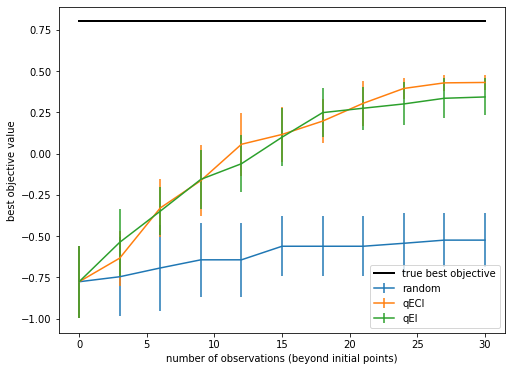

In [23]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


obj = Cosine8()
#obj = Hartmann(negate=True, dim=6)
GLOBAL_MAXIMUM = obj.optimal_value

print(GLOBAL_MAXIMUM)

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_ei)
y_rnd = np.asarray(best_random_all)
y_ind = np.asarray(best_observed_all_ind)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qECI", linewidth=1.5)
ax.errorbar(iters, y_ind.mean(axis=0), yerr=ci(y_ind), label="qEI", linewidth=1.5)

plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)
#ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")